In [1]:
import numpy as np 
import pandas as pd 
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix, roc_auc_score, roc_curve

import os
print(os.listdir("../input"))

['HR_comma_sep.csv']


/opt/conda/lib/python3.6/site-packages/sklearn/ensemble/weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


In [2]:
# Util function(s)

def print_matrix(model, X_test, y_test, xlabel='Predicted', ylabel='True class', title=''):
    y_pred = model.predict(X_test)
    matrix = confusion_matrix(y_pred, y_test, [1,0])
    sns.heatmap(matrix, annot=True, fmt='.2f', xticklabels=['Left', 'Stayed'], yticklabels=['Left', 'Stayed'])
    plt.ylabel(ylabel)
    plt.xlabel(xlabel)
    plt.title(title)
    plt.show()
    
def print_roc(model, X_test, y_test, label='', xlabel='False Positive Rate', ylabel='True Positive Rate', title=''):
    y_pred = model.predict_proba(X_test)[:, 1]
    fpr_lm, tpr_lm, _ = roc_curve(y_test, y_pred)
    plt.plot(fpr_lm, tpr_lm, label=label)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.title(title)
    plt.legend(loc='best')
    plt.legend()
    plt.grid()
    plt.show()

## About Features

 - satisfaction_level: Level of satisfaction {0–1}.
 - last_evaluationTime: Time since last performance evaluation (in years).
 - number_project: Number of projects completed while at work.
 - average_montly_hours: Average monthly hours at workplace.
 - time_spend_company: Number of years spent in the company.
 - Work_accident: Whether the employee had a workplace accident.
 - left: Whether the employee left the workplace or not {0, 1}.
 - promotion_last_5years: Whether the employee was promoted in the last five years.
 - sales: Department the employee works for.
 - salary: Relative level of salary {low, medium, high}.

## Importing Dataset

In [3]:
df = pd.read_csv('../input/HR_comma_sep.csv')
df.head()
dFrame = df

In [4]:
print(df.shape)
print()
print(df.dtypes)
print()
print(df.isnull().sum())

(14999, 10)

satisfaction_level       float64
last_evaluation          float64
number_project             int64
average_montly_hours       int64
time_spend_company         int64
Work_accident              int64
left                       int64
promotion_last_5years      int64
sales                     object
salary                    object
dtype: object

satisfaction_level       0
last_evaluation          0
number_project           0
average_montly_hours     0
time_spend_company       0
Work_accident            0
left                     0
promotion_last_5years    0
sales                    0
salary                   0
dtype: int64


## Data Preprocessing

In [5]:
df.rename(columns={"sales":"department"}, inplace=True)

In [6]:
#Mapping categorical salary
df.salary = df.salary.map({"low": 0, "medium": 1, "high": 2})

In [7]:
df.head()

,satisfaction_level,last_evaluation,number_project,average_montly_hours,time_spend_company,Work_accident,left,promotion_last_5years,department,salary
0,0.38,0.53,2,157,3,0,1,0,sales,0
1,0.80,0.86,5,262,6,0,1,0,sales,1
2,0.11,0.88,7,272,4,0,1,0,sales,1
3,0.72,0.87,5,223,5,0,1,0,sales,0
4,0.37,0.52,2,159,3,0,1,0,sales,0


In [8]:
df.groupby("left").mean()

,satisfaction_level,last_evaluation,number_project,average_montly_hours,time_spend_company,Work_accident,promotion_last_5years,salary
left,,,,,,,,
0,0.666810,0.715473,3.786664,199.060203,3.380032,0.175009,0.026251,0.650945
1,0.440098,0.718113,3.855503,207.419210,3.876505,0.047326,0.005321,0.414730


## Exploratory Data Analysis

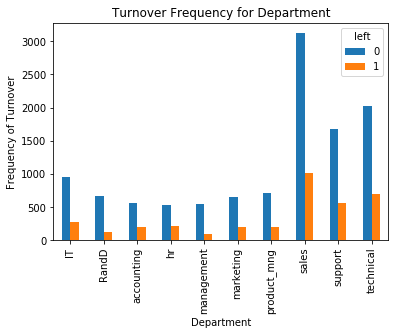

In [9]:
pd.crosstab(df.department, df.left).plot(kind="bar")
plt.title("Turnover Frequency for Department")
plt.xlabel("Department")
plt.ylabel("Frequency of Turnover")
plt.show()

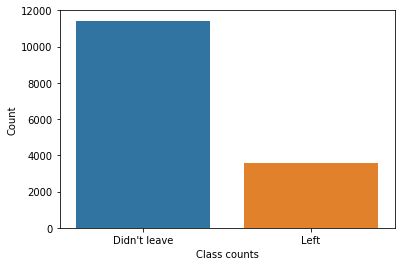

In [10]:
sns.countplot(df.left)
plt.xticks((0, 1), ["Didn't leave", "Left"])
plt.xlabel("Class counts")
plt.ylabel("Count")
plt.show()

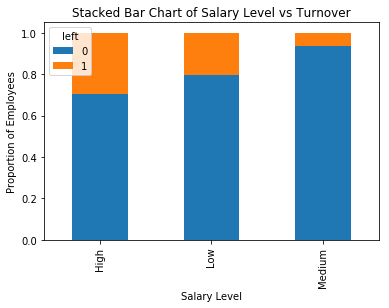

In [11]:
pd.crosstab(df.salary, df.left).div(pd.crosstab(df.salary, df.left).sum(1).astype(float), axis=0).plot(kind='bar', stacked=True)
plt.xticks((0, 1, 2), ["High", "Low", "Medium"])
plt.title("Stacked Bar Chart of Salary Level vs Turnover")
plt.xlabel("Salary Level")
plt.ylabel("Proportion of Employees")
plt.show()

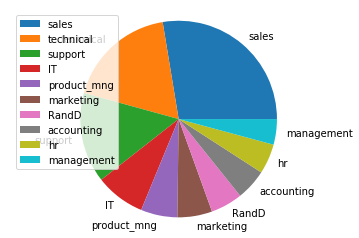

In [12]:
plt.pie(df.department.value_counts().values, labels=df.department.value_counts().index)
plt.legend()
plt.axis("equal")
plt.show()

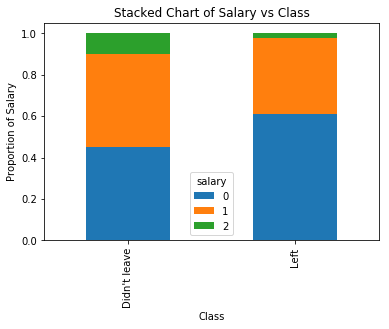

In [13]:
pd.crosstab(df.left, df.salary).div(pd.crosstab(df.left, df.salary).sum(1).astype(float), axis=0).plot(kind='bar', stacked=True)
plt.title("Stacked Chart of Salary vs Class")
plt.xlabel("Class")
plt.xticks([0, 1], ["Didn't leave", "Left"])
plt.ylabel("Proportion of Salary")
plt.show()

In [14]:
# Create dummy variables for department feature
df = pd.get_dummies(df, columns=["department"], drop_first=True)
#df.head()

In [15]:
# Convert dataframe into numpy objects and split them into train and test sets: 80/20
X = df.loc[:, df.columns != "left"].values
y = df.loc[:, df.columns == "left"].values.flatten()

# Original minority class
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=1)

print ("Original shape:", X_train.shape, y_train.shape )

Original shape: (11999, 17) (11999,)


## Random Forest

In [16]:
# Build random forest classifier

pip_rf = make_pipeline(StandardScaler(), RandomForestClassifier(n_estimators=500, class_weight="balanced", random_state=123))
    
hyperparam_grid = {
    'randomforestclassifier__n_estimators': [10, 50, 100, 500],
    'randomforestclassifier__max_features': ["sqrt", "log2", 0.4, 0.5],
    'randomforestclassifier__min_samples_leaf': [1, 3, 5],
    'randomforestclassifier__criterion': ["gini", "entropy"]}
    
gs_rf = GridSearchCV(pip_rf,
                    hyperparam_grid,
                    scoring='f1',
                    cv=10,
                    n_jobs=-1)
gs_rf.fit(X_train, y_train)

for hyperparam in gs_rf.best_params_.keys():
    print (hyperparam[hyperparam.find('__') + 2:], ':', gs_rf.best_params_[hyperparam]   )
    
print ('Best 10-folds CV f1-score: {:.2f}%.'.format(gs_rf.best_score_ * 100))

criterion : gini
max_features : 0.5
min_samples_leaf : 1
n_estimators : 500
Best 10-folds CV f1-score: 98.19%.


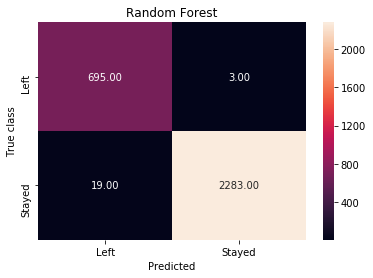

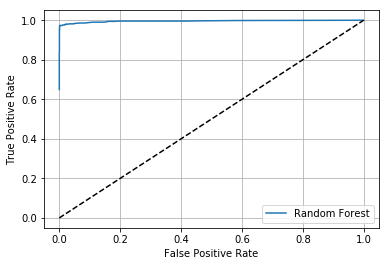

In [17]:
print_matrix(gs_rf, X_test, y_test, title='Random Forest')
print_roc(gs_rf, X_test, y_test,'Random Forest')

## K-Nearest Neighbors

In [18]:
# Build KNN classifier
pip_knn = make_pipeline(StandardScaler(), KNeighborsClassifier())
hyperparam_range = range(1, 20)
gs_knn = GridSearchCV(pip_knn,
                      param_grid={'kneighborsclassifier__n_neighbors': hyperparam_range,
                                  'kneighborsclassifier__weights': ['uniform', 'distance']},
                      scoring='f1',
                      cv=10,
                      n_jobs=-1)
gs_knn.fit(X_train, y_train)

for hyperparam in gs_knn.best_params_.keys():
    print (hyperparam[hyperparam.find("__") + 2:], ':', gs_knn.best_params_[hyperparam]) 
print ('Best 10-folds CV f1-score: {:.2f}%.'.format((gs_knn.best_score_) * 100))

n_neighbors : 1
weights : uniform
Best 10-folds CV f1-score: 92.87%.


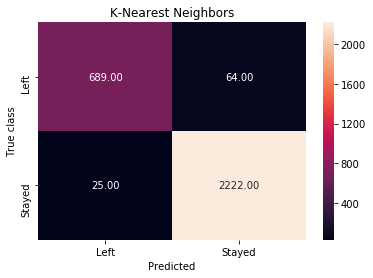

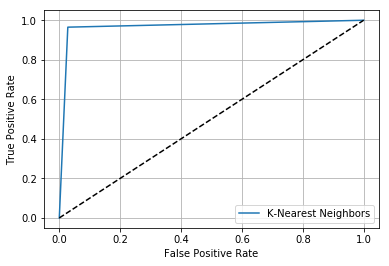

In [19]:
print_matrix(gs_knn, X_test, y_test, title='K-Nearest Neighbors')
print_roc(gs_knn, X_test, y_test,'K-Nearest Neighbors')

## Support Vector Machine (SVM)

In [20]:
# Build SVM classifier
clf_svc = make_pipeline(StandardScaler(),
                        SVC(C=0.01,
                            gamma=0.1,
                            kernel='poly',
                            degree=5,
                            coef0=10,
                            probability=True))
clf_svc.fit(X_train, y_train)
svc_cv_scores = cross_val_score(clf_svc,
                                X=X_train,
                                y=y_train,
                                scoring='f1',
                                cv=10,
                                n_jobs=-1)
print ('The 10-folds CV f1-score is: {:.2f}%'.format(np.mean(svc_cv_scores) * 100))

The 10-folds CV f1-score is: 92.18%


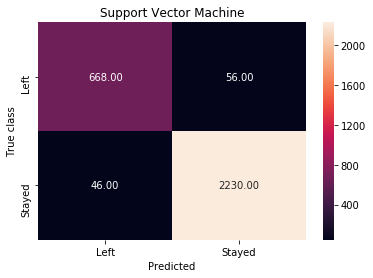

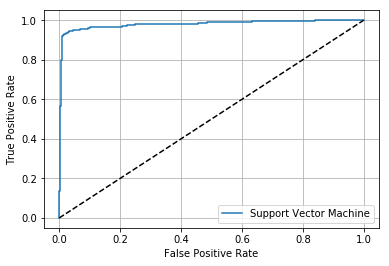

In [21]:
print_matrix(clf_svc, X_test, y_test, title='Support Vector Machine')
print_roc(clf_svc, X_test, y_test,'Support Vector Machine')

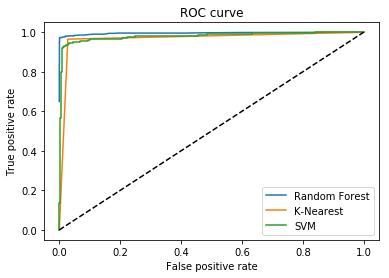

In [22]:
# Conclusion
y_pred_rf = gs_rf.predict_proba(X_test)[:, 1]
fpr_rf_lm, tpr_rf_lm, _ = roc_curve(y_test, y_pred_rf)
plt.plot(fpr_rf_lm, tpr_rf_lm, label='Random Forest')

y_pred_knn = gs_knn.predict_proba(X_test)[:, 1]
fpr_knn_lm, tpr_knn_lm, _ = roc_curve(y_test, y_pred_knn)
plt.plot(fpr_knn_lm, tpr_knn_lm, label='K-Nearest')

y_pred_scv = clf_svc.predict_proba(X_test)[:, 1]
fpr_scv_lm, tpr_scv_lm, _ = roc_curve(y_test, y_pred_scv)
plt.plot(fpr_scv_lm, tpr_scv_lm, label='SVM')

plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.legend()
plt.show()

## Feature Importance

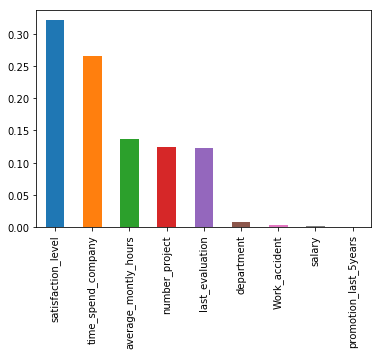

In [23]:
features = gs_rf.best_estimator_.steps[1][1].feature_importances_
index = dFrame.columns[dFrame.columns != 'left']
imp_features = pd.Series(data=features[:9], index=index)
imp_features.sort_values(ascending=False, inplace=True)
imp_features.plot(kind='bar')
plt.show()